### Problem Statement:

Given a random base image and a style-reference image, we are trying to generate a new image such that it'll have the styles from reference image with the features of base image. We'll use pretrained VGG19 architecture based on ImageNet, and use it for the purpose of style transfer. 

Real life application of this approach can be used to design filters for different camera applications which would add a new style filter over a base image

#### Import the libraries and Input to the model


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
from keras.preprocessing.image import load_img


#### Loading style and original images

In [2]:
base_image_path = 'original.jpg'
style_image_path = 'style.jpg'

result_prefix = "image_generated"

#Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

#Dimensions of the generated image
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_rows = 400
img_cols = int(width * img_rows / height)

##### Using image of horse as base image and splash of color as style image. 
Here, we are not actually training any weights but generating the candidate image using training, hence less epcohs are needed

Image A: Original image to which we'll apply style


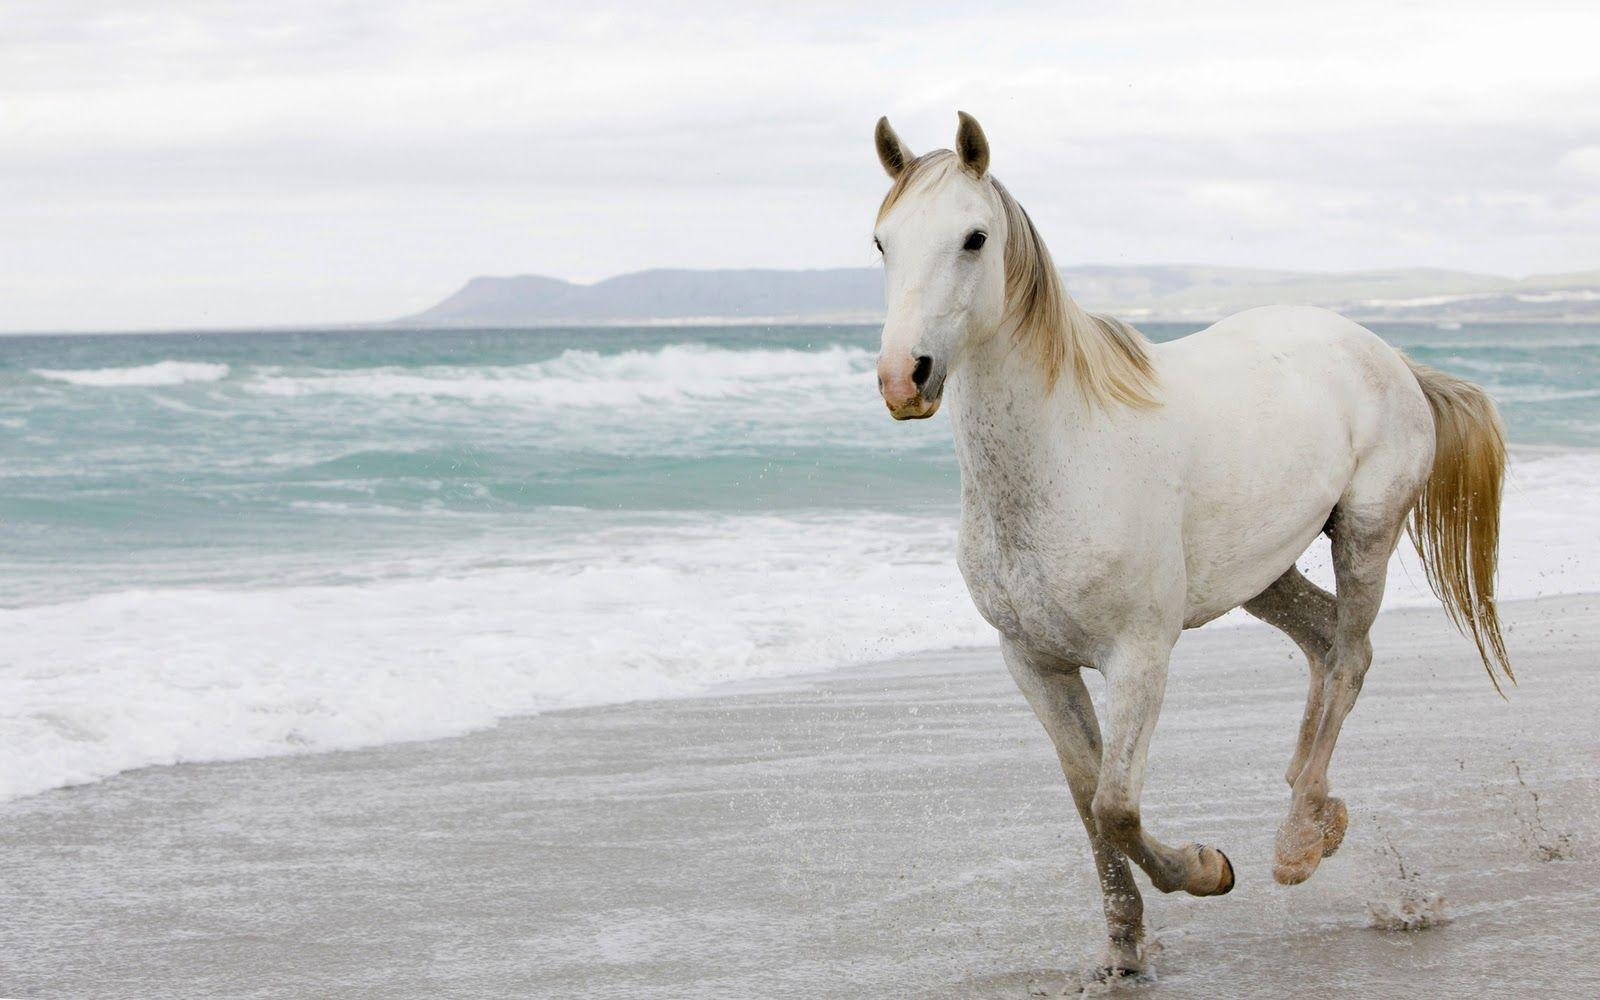

Image B: Abstract image used to transfer its style


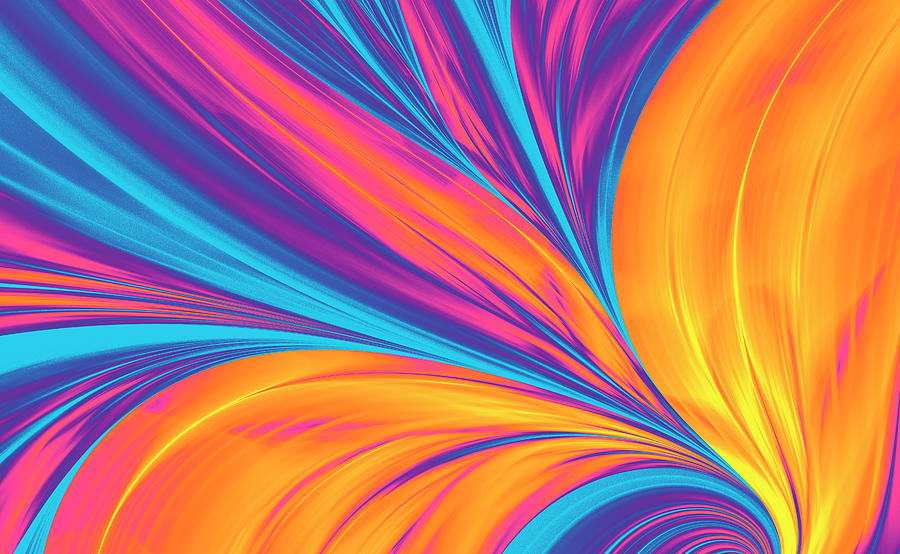

In [3]:
from IPython.display import display,Image
print("Image A: Original image to which we'll apply style")
display(Image(base_image_path))
print("Image B: Abstract image used to transfer its style")
display(Image(style_image_path))

##### Preprocessing of image:
We'll define a function which will open,resize, and format pictures into appropriate size, and the resulted image will be given to the neural network

In [4]:
def preprocess_image(image_path):
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_rows, img_cols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

Once the candidate image is generated, we will plot it to see the result after deprocessing it using the following function.

In [5]:
def deprocess_image(x):
    #Util function to convert a tensor into a valid image
    x = x.reshape((img_rows, img_cols, 3))
    #Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    #'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

### Loss Function
Now we will define the loss functions for the style loss and the content loss. 

For the style loss, we will define the `Gram matrix`.

We may see an image as distribution over different feature vectors. Each feature vector in a layer captures some aspect of image. For example, in the initial layer, feature vectors captures edges. Gram matrix captures correlation between different feature vectors, not the presence or absence of specific features. Gram matrix is the product between a matrix and its transpose.

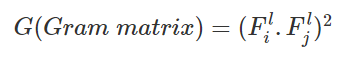

In [6]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

`Style Loss`

The style loss is sum of L2 distances between the Gram matrices of the representations of the generated image and the style image, extracted from different layers of CNN(here, VGGNet). The general idea is to capture style (color/texture/shapes/edges etc) at different layers.

Let $A^l$ and $G^l$ style representations of generated(artistic) and style image in layer $l$. The contribution of that layer to the total loss is:

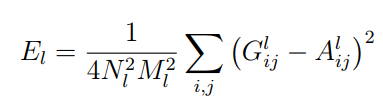

and the total style loss is: 

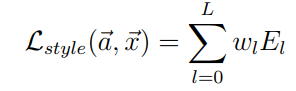

In [7]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_rows * img_cols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

The style loss is designed to maintain the design of the reference image in the generated image.
It is based on gram matrix which captures the feature maps from the style reference and the style image.

`Content Loss`

The content loss is a L2 distance between the features of the generated image and the features of the content image. Let $P^l$ and $F^l$ be feature representation of content image and generated image in layer $l$. We then define the squared-error loss between the two feature representations as:
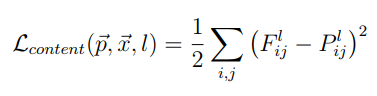

In [8]:
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

`Total Loss`

One downside to this basic implementation is that it produces a lot of high frequency artifacts. Decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the total variation loss

In [9]:
def total_variation_loss(x):
    a = tf.square(x[:, : img_rows - 1, : img_cols - 1, :] - x[:, 1:, : img_cols - 1, :])
    b = tf.square(x[:, : img_rows - 1, : img_cols - 1, :] - x[:, : img_rows - 1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

#### Building the VGG19 model

In [10]:
#Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

#Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

#Set up a model that returns the activation values for every layer in VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

print(model.summary())

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

#### Code to compute style transfer loss

In [11]:
#List of layers to use for the style loss.
style_layer_names = ["block1_conv1","block2_conv1","block3_conv1","block4_conv1","block5_conv1",]

#The layer to use for the content loss.
content_layer_name = "block5_conv2"

def compute_loss(combination_image, base_image, style_image):
    input_tensor = tf.concat([base_image, style_image, combination_image], axis=0)
    features = feature_extractor(input_tensor)

    #Initialize the loss
    loss = tf.zeros(shape=())

    #Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(base_image_features, combination_features)
    
    #Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss


#### Add a tf.function decorator to loss & gradient computation

In [12]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

#### Training Loop

Repeatedly run vanilla gradient descent steps to minimize the loss, and save the resulting image every 100 iterations.

We decay the learning rate by 0.96 every 100 steps.

In [13]:
optimizer = keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96))

base_image = preprocess_image(base_image_path)
style_image = preprocess_image(style_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 50
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_image)
    optimizer.apply_gradients([(grads, combination_image)])
    print("Iteration %d: loss=%.2f" % (i, loss))
    img = deprocess_image(combination_image.numpy())
    fname = result_prefix + "_at_iteration_%d.png" % i
    keras.preprocessing.image.save_img(fname, img)

Iteration 1: loss=195825.97
Iteration 2: loss=181785.38
Iteration 3: loss=157732.78
Iteration 4: loss=131354.64
Iteration 5: loss=104145.15
Iteration 6: loss=82246.98
Iteration 7: loss=67412.27
Iteration 8: loss=57677.85
Iteration 9: loss=51109.77
Iteration 10: loss=46271.79
Iteration 11: loss=42429.80
Iteration 12: loss=39273.00
Iteration 13: loss=36622.61
Iteration 14: loss=34325.75
Iteration 15: loss=32358.30
Iteration 16: loss=30634.99
Iteration 17: loss=29130.35
Iteration 18: loss=27797.52
Iteration 19: loss=26613.32
Iteration 20: loss=25562.13
Iteration 21: loss=24619.12
Iteration 22: loss=23762.42
Iteration 23: loss=22996.31
Iteration 24: loss=22288.98
Iteration 25: loss=21644.45
Iteration 26: loss=21053.73
Iteration 27: loss=20511.91
Iteration 28: loss=20007.30
Iteration 29: loss=19543.92
Iteration 30: loss=19107.65
Iteration 31: loss=18705.35
Iteration 32: loss=18325.55
Iteration 33: loss=17976.71
Iteration 34: loss=17643.91
Iteration 35: loss=17331.71
Iteration 36: loss=17036

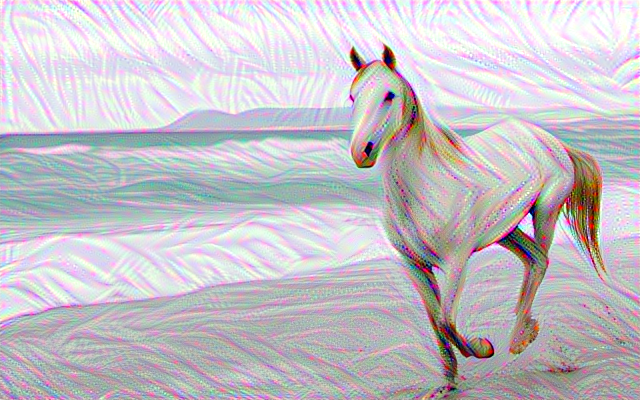

In [14]:
display(Image(result_prefix+"_at_iteration_50.png"))